In [1]:
from sklearn.model_selection import train_test_split
import onnxruntime as rt
import onnx
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from skl2onnx import convert_sklearn
from sklearn.preprocessing import StandardScaler
# define a XGBoost classifier
import xgboost as xgb
import warnings
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin


warnings.filterwarnings("ignore")  # Ignore runtime warnings
# Temporarily adjust pandas display settings for large DataFrames
pd.set_option('display.max_rows', 100)  # Ensure 100 rows can be displayed
pd.set_option('display.max_columns', None)  # Ensure all columns can be displayed
pd.set_option('display.width', None)  # Automatically adjust display width to terminal size
pd.set_option('display.max_colwidth', None)  # Ensure full width of column content is shown
pd.set_option('display.float_format', '{:.4f}'.format)  # Format the float numbers for better readability

# Data preprocessing and feature selection

Our data consists of binary data so we only want to calculate the Z-score for non-binary colomns

In [2]:
# Load the dataset
data = pd.read_csv('data/synth_data_for_training.csv')

Before cleaning:
Missing values per column:
Total missing values: 0


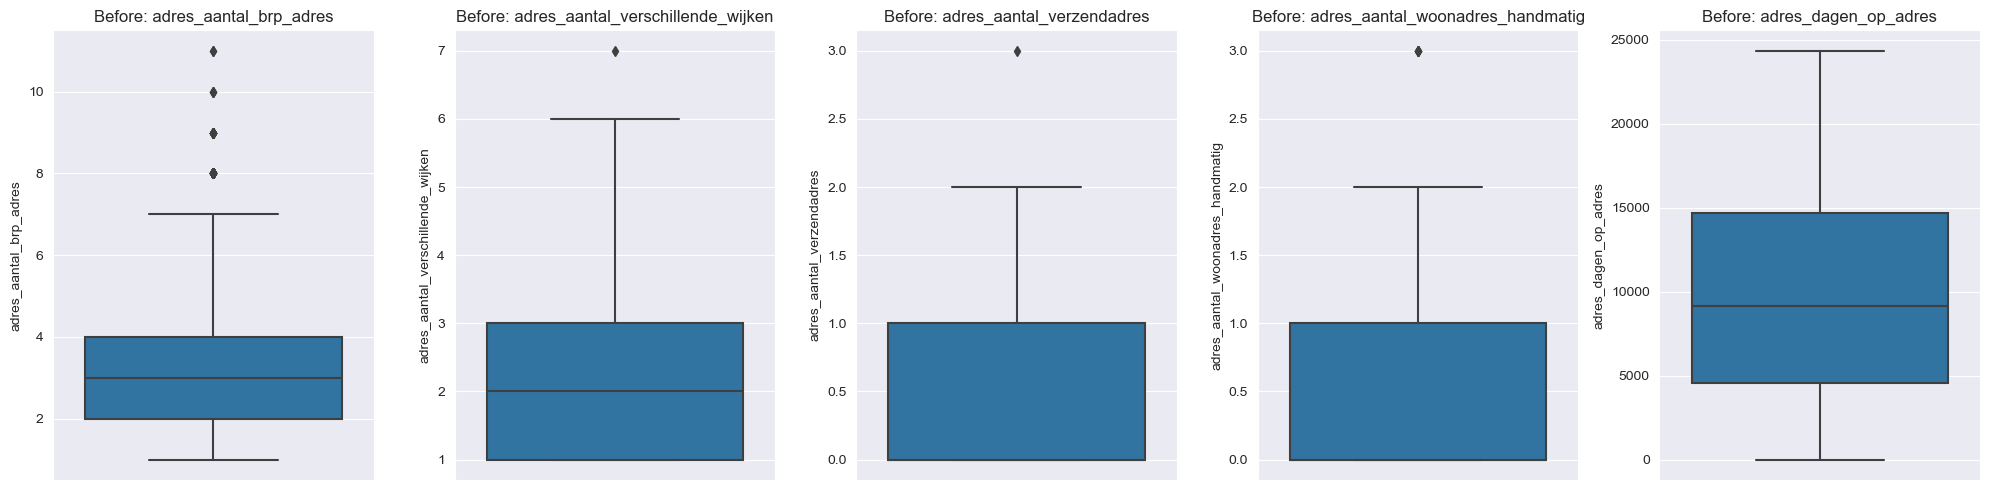

After cleaning:
Missing values per column:
Total missing values: 0


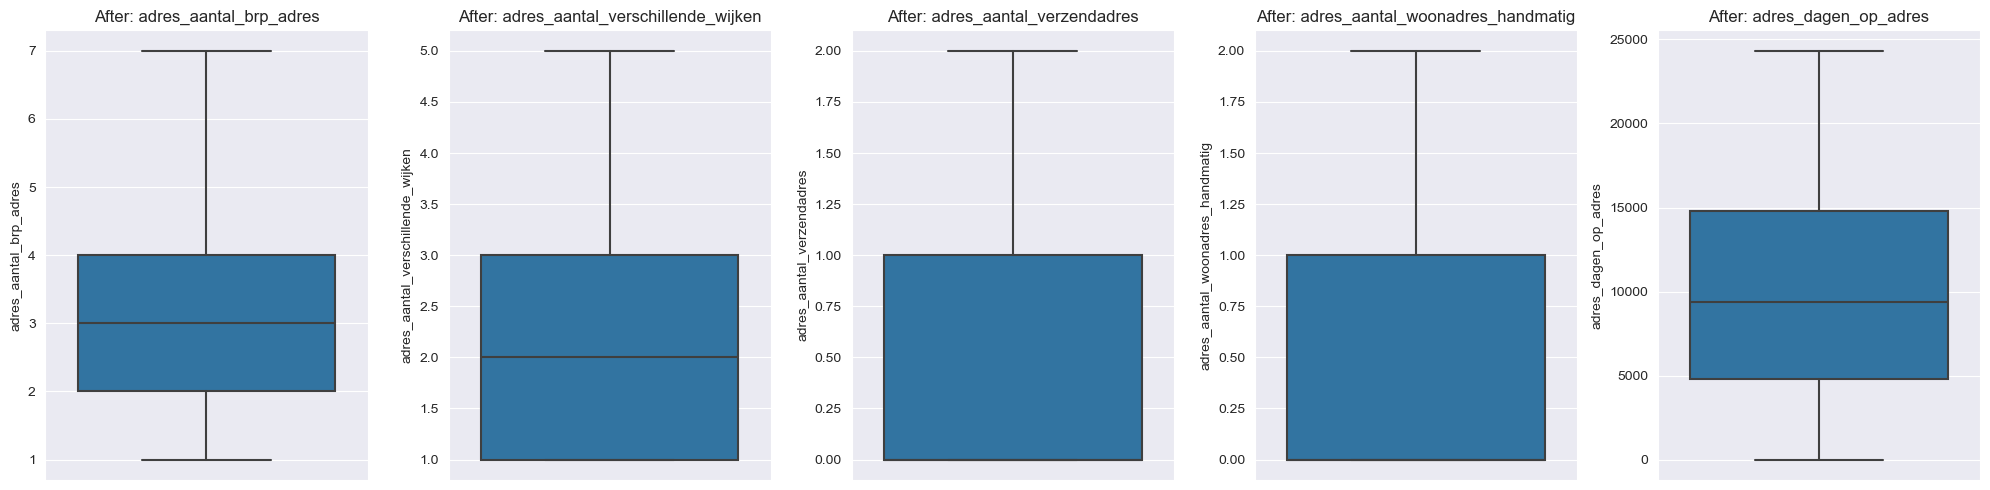

Shape before cleaning: (12645, 316)
Shape after cleaning: (10182, 316)


In [3]:
print("Before cleaning:")
print("Missing values per column:")
print("Total missing values:", data.isna().sum().sum())

# Identify non-binary columns
non_binary_columns = [col for col in data.columns if not (np.isin(data[col].unique(), [0, 1]).all() and len(data[col].unique()) == 2)]

# Calculate Z-scores for non-binary columns only
z_scores_non_binary = np.abs(stats.zscore(data[non_binary_columns], nan_policy='omit'))

# Mask to identify rows with outliers in non-binary columns
outlier_mask = (z_scores_non_binary > 3.5).any(axis=1)

# Select a subset of non-binary columns for plotting to avoid large image sizes
plot_columns = non_binary_columns[:5]  # Adjust this number based on your specific needs

# Plot outliers for the selected columns before removing
plt.figure(figsize=(20, 5))
for i, col in enumerate(plot_columns, 1):
    plt.subplot(1, len(plot_columns), i)
    sns.boxplot(y=data[col])
    plt.title(f'Before: {col}')
plt.tight_layout()
plt.show()

# Remove outliers from the dataset using the previously defined full_outlier_mask
data_cleaned = data[~outlier_mask]

print("After cleaning:")
print("Missing values per column:")
print("Total missing values:", data_cleaned.isna().sum().sum())

# Plot outliers for the selected columns after removing
plt.figure(figsize=(20, 5))
for i, col in enumerate(plot_columns, 1):
    plt.subplot(1, len(plot_columns), i)
    sns.boxplot(y=data_cleaned[col])
    plt.title(f'After: {col}')
plt.tight_layout()
plt.show()

# Print the shape of the dataset before and after cleaning
print("Shape before cleaning:", data.shape)
print("Shape after cleaning:", data_cleaned.shape)

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class FeatureZeroing(BaseEstimator, TransformerMixin):
    def __init__(self, non_fair_keywords):
        self.non_fair_keywords = non_fair_keywords
        self.removed_features = []  # Initialize list of zeroed features

    def fit(self, X, y=None):
        # No fitting process needed for zeroing features, but method required for pipeline compatibility
        return self

    def transform(self, X):
        # Convert DataFrame to a copy to avoid changing original data
        X_transformed = X.copy()

        # Make the keywords case-insensitive
        non_fair_keywords_lower = [keyword.lower() for keyword in self.non_fair_keywords]

        # Identify and zero out non-fair features
        for feature in X_transformed.columns:
            if any(nfk in feature.lower() for nfk in non_fair_keywords_lower):
                X_transformed[feature] = 0
                self.removed_features.append(feature)  # Track zeroed features

        # Return modified DataFrame
        return X_transformed

# Define non-fair keywords (same as before)
non_fair_keywords = [
    "adres", "woonadres", "verzendadres", "buurt", "wijk", "plaats", "persoon_geslacht_vrouw", "taal", "kind", "ontheffing", "leeftijd"
]

In [5]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming 'data_cleaned' is your cleaned DataFrame and 'non_fair_keywords' is defined
# Specify the features and the target
y = data_cleaned['checked']
X = data_cleaned.drop(['checked'], axis=1)
X = X.astype(np.float32)

# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

# Initialize and apply the feature zeroing transformation (assuming implementation exists)
feature_zeroing = FeatureZeroing(non_fair_keywords=non_fair_keywords)
X_train = feature_zeroing.transform(X_train)

# Print out all the features that have been zeroed out
print("Features zeroed out:")
for feature in feature_zeroing.removed_features:
    print(feature)
# 
# # Use SMOTE for oversampling and RandomUnderSampler for undersampling
# # Here, sampling_strategy for SMOTE is set to 0.5 for oversampling,
# # meaning the minority class will be oversampled to be half the size of the majority class
# smote = SMOTE(random_state=42, sampling_strategy=0.5)
# 
# # After applying SMOTE, we use RandomUnderSampler to reduce the size of the majority class,
# # making the final ratio closer to 1:1. You might adjust 'sampling_strategy' based on your needs
# under_sampler = RandomUnderSampler(random_state=42)
# 
# # Combine SMOTE and RandomUnderSampler in a pipeline
# resample_pipeline = ImbPipeline(steps=[('SMOTE', smote), ('Under', under_sampler)])
# 
# # Apply the resampling pipeline to the training data
# X_train, y_train = resample_pipeline.fit_resample(X_train, y_train)
# # 
# 
# # X_train, y_train = smote.fit_resample(X_train, y_train)
# # Checking the class distribution after resampling
# print(y_train.value_counts(normalize=True))


Features zeroed out:
adres_aantal_brp_adres
adres_aantal_verschillende_wijken
adres_aantal_verzendadres
adres_aantal_woonadres_handmatig
adres_dagen_op_adres
adres_recentst_onderdeel_rdam
adres_recentste_buurt_groot_ijsselmonde
adres_recentste_buurt_nieuwe_westen
adres_recentste_buurt_other
adres_recentste_buurt_oude_noorden
adres_recentste_buurt_vreewijk
adres_recentste_plaats_other
adres_recentste_plaats_rotterdam
adres_recentste_wijk_charlois
adres_recentste_wijk_delfshaven
adres_recentste_wijk_feijenoord
adres_recentste_wijk_ijsselmonde
adres_recentste_wijk_kralingen_c
adres_recentste_wijk_noord
adres_recentste_wijk_other
adres_recentste_wijk_prins_alexa
adres_recentste_wijk_stadscentru
adres_unieke_wijk_ratio
afspraak_afgelopen_jaar_monitoring_insp__wet_taaleis_na_12_mnd_n_a_v__taa04_____geen_maatregel
afspraak_afgelopen_jaar_ontheffing
afspraak_afgelopen_jaar_ontheffing_taaleis
afspraak_verzenden_beschikking_i_v_m__niet_voldoen_aan_wet_taaleis
belemmering_hist_taal
beschikbaarhei

# Feature scaling and model training

In [6]:
from sklearn.metrics import make_scorer, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel


# Custom scorer function for F0.5 score
def f05_scorer(y_true, y_pred):
    precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, beta=0.5, average='binary')
    return f_score

# Making the F0.5 scorer
f05 = make_scorer(f05_scorer, greater_is_better=True)


# Classifier to be used in the pipeline
classifier = GradientBoostingClassifier(random_state=0)

# Initialize RandomForestClassifier for feature selection
clf = RandomForestClassifier(random_state=0)

# Initialize SelectFromModel
sfm = SelectFromModel(clf, threshold='mean')

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Define SMOTE and RandomUnderSampler within the pipeline
smote = SMOTE(sampling_strategy='auto')  # or use a specific strategy
under_sampler = RandomUnderSampler(sampling_strategy='auto')  # or use a specific strategy

# Now the pipeline uses ImbPipeline from imblearn which allows for resampling
pipeline = ImbPipeline([
    ('scaling', StandardScaler()),
    ('feature_selection', sfm),
    ('oversampling', smote),
    ('undersampling', under_sampler),
    ('classification', classifier)
])


# Parameters grid
param_grid = {
    'classification__n_estimators': [200],
    'classification__max_depth': [3]
}

# Grid search with F2 score as the metric
grid_search = GridSearchCV(pipeline, param_grid, scoring=f05, cv=5)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best F2 Score:", best_score)
y_pred = grid_search.predict(X_test)


In [7]:
# check what the majority class if
y.value_counts(normalize=True)

checked
0   0.9066
1   0.0934
Name: proportion, dtype: float64

In [8]:
# import numpy as np
# import onnxruntime as rt
# from sklearn.datasets import load_iris
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from xgboost import XGBClassifier
# from skl2onnx import convert_sklearn, update_registered_converter
# from skl2onnx.common.data_types import FloatTensorType
# from skl2onnx.common.shape_calculator import calculate_linear_classifier_output_shapes
# from onnxmltools.convert.xgboost.operator_converters.XGBoost import convert_xgboost
# from sklearn.metrics import precision_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.metrics import make_scorer, precision_score, accuracy_score, recall_score, f1_score
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.feature_selection import SelectFromModel
# 
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.metrics import precision_recall_fscore_support
# 
# # # Custom scorer function for F0.5 score
# def f05_scorer(y_true, y_pred):
#     precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, beta=0.5, average='binary')
#     return f_score
# 
# f05 = make_scorer(f05_scorer, greater_is_better=True)
# 
# 
# # Assuming 'y' is your target variable array
# # Calculate the weights for each class to make the dataset balanced
# class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
# scale_pos_weight = class_weights[0] / class_weights[1]  # 0 is majority class
# 
# # Initialize RandomForestClassifier for feature selection
# clf = RandomForestClassifier(random_state=0)
# 
# # Initialize SelectFromModel
# sfm = SelectFromModel(clf, threshold='mean')
# 
# 
# 
# # # Define the parameter grid
# # param_grid = {
# #     'xgb__max_depth': [5],
# #     'xgb__learning_rate': [0.2],
# #     'xgb__n_estimators': [300],
# #     'xgb__subsample': [1.0]
# #     # Add other parameters you want to tune
# # }
# 
# # Define the parameter grid
# param_grid = {
#     'xgb__max_depth': [3, 5],  # Shallower trees to prevent overfitting
#     'xgb__learning_rate': [0.01, 0.05],  # Slower learning rates can help generalize better
#     'xgb__n_estimators': [50, 100, 150, 200],  # Fewer trees to prevent overfitting
#     # 'xgb__subsample': [0.6, 0.7, 0.8],  # Subsampling to add randomness to make training robust
#     # 'xgb__colsample_bytree': [0.6, 0.7, 0.8],  # Subsample features by tree to prevent overfitting
#     # 'xgb__min_child_weight': [1, 3, 5],  # Higher values to control over-fitting
#     # 'xgb__gamma': [0, 0.1, 0.5],  # Minimum loss reduction required to make a further partition
#     # 'xgb__lambda': [1, 1.5, 2],  # L2 regularization term on weights to smooth the final weights
#     # 'xgb__alpha': [0, 0.1, 0.5]  # L1 regularization term on weights for sparsity
# }
# 
# 
# 
# classifier = XGBClassifier(scale_pos_weight=scale_pos_weight)
# pipeline = Pipeline([("scaler", StandardScaler()),('feature_selection', sfm), ("xgb", classifier)])
# 
# grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=f05, cv=5, verbose=1)
# 
# grid_search.fit(X_train, y_train)
# pipeline = grid_search.best_estimator_
# 
# # print best parameters
# print("Best parameters found by grid search:"
#       , grid_search.best_params_)
# 
# # The conversion fails but it is expected.
# 
# # Assuming X is your feature matrix after all preprocessing steps have been applied
# number_of_features = X.shape[1]  # This should be the actual number of features in your dataset
# 
# # Now update the initial_types to reflect the correct shape
# initial_type = [('input', FloatTensorType([None, number_of_features]))]
# 
# # Now attempt to convert it again
# try:
#     model_onnx = convert_sklearn(
#         pipeline,
#         "pipeline_xgboost",
#         initial_types=initial_type,
#         target_opset={"": 12, "ai.onnx.ml": 2}
#     )
# except Exception as e:
#     print(e)
# else:
#     # If successful, write the model to a file
#     with open("model_1.onnx", "wb") as f:
#         f.write(model_onnx.SerializeToString())
# 
# 
# 
# # Register the converter for XGBClassifier
# update_registered_converter(
#     XGBClassifier,
#     "XGBoostXGBClassifier",
#     calculate_linear_classifier_output_shapes,
#     convert_xgboost,
#     options={"nocl": [True, False], "zipmap": [True, False, "columns"]}
# )
# 
# 
# 
# # Correct the initial_types to reflect the actual number of features
# initial_type = [('input', FloatTensorType([None, number_of_features]))]
# 
# 
# # Convert the pipeline to ONNX format using the corrected initial_types
# model_onnx = convert_sklearn(
#     pipeline,
#     "pipeline_xgboost",
#     initial_types=initial_type,  # This now uses the variable with the correct number of features
#     target_opset={"": 12, "ai.onnx.ml": 2}
# )
# 
# 
# # Write the ONNX model to a file
# with open("model_1.onnx", "wb") as f:
#     f.write(model_onnx.SerializeToString())
# 
# 
# 
# # Load the ONNX model and create an inference session
# sess = rt.InferenceSession("model_1.onnx")
# 
# # Get the input name for the ONNX model
# input_name = sess.get_inputs()[0].name
# 
# # Assuming X_test is a NumPy array and ready for inference
# # Convert X_test to a float32 NumPy array if it's not already
# input_data = X_test[:5].astype(np.float32) if isinstance(X_test, np.ndarray) else X_test[:5].values.astype(np.float32)
# 
# # Run the inference session
# pred_onnx = sess.run(None, {input_name: input_data})
# 
# 
# y_pred = pipeline.predict(X_test)
# 


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found by grid search: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 5, 'xgb__n_estimators': 200}
Unable to find a shape calculator for type '<class 'xgboost.sklearn.XGBClassifier'>'.
It usually means the pipeline being converted contains a
transformer or a predictor with no corresponding converter
implemented in sklearn-onnx. If the converted is implemented
in another library, you need to register
the converted so that it can be used by sklearn-onnx (function
update_registered_converter). If the model is not yet covered
by sklearn-onnx, you may raise an issue to
https://github.com/onnx/sklearn-onnx/issues
to get the converter implemented or even contribute to the
project. If the model is a custom model, a new converter must
be implemented. Examples can be found in the gallery.


In [9]:
# from sklearn.metrics import make_scorer, precision_recall_fscore_support
# from sklearn.model_selection import GridSearchCV, train_test_split
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, RobustScaler
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.feature_selection import SelectFromModel
# # get logistic regression
# from sklearn.linear_model import LogisticRegression
# 
# from sklearn.metrics import precision_score
# from sklearn.metrics import make_scorer
# 
# # Create a scorer that focuses on precision for the positive class
# precision_scorer = make_scorer(precision_score, pos_label=1)
# 
# # Define a parameter grid to search over
# param_grid = {
#     'classification__C': [0.001, 0.01, 0.1, 1, 10, 100], # Regularization parameter
#     'classification__solver': ['newton-cg', 'lbfgs', 'liblinear'], # Optimization algorithms
#     'classification__max_iter': [200, 500, 1000] # Maximum number of iterations
# 
# }
# 
# classifier = LogisticRegression(random_state=0, class_weight='balanced', max_iter=1000)
# 
# # Initialize RandomForestClassifier for feature selection
# clf = RandomForestClassifier(random_state=0, class_weight='balanced')
# 
# # Initialize SelectFromModel
# sfm = SelectFromModel(clf, threshold='mean')
# 
# # Setting up the pipeline
# pipeline = Pipeline([
#     ('scaling', StandardScaler()),
#     ('feature_selection', sfm),
#     ('classification', classifier)
# ])
# 
# # Initialize GridSearchCV with the precision scorer
# grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring=precision_scorer, cv=5)
# 
# # Fit GridSearchCV to the training data
# grid_search.fit(X_train, y_train)
# 
# # Get the best combination of parameters
# best_params = grid_search.best_params_
# print(f"Best parameters for precision: {best_params}")
# 
# # Use the best estimator to make predictions
# y_pred = grid_search.predict(X_test)

In [10]:
# Let's evaluate the model

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

# print confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

Accuracy: 0.9116
Precision: 0.7500
Recall: 0.0789
F1 Score: 0.1429


array([[1842,    5],
       [ 175,   15]])

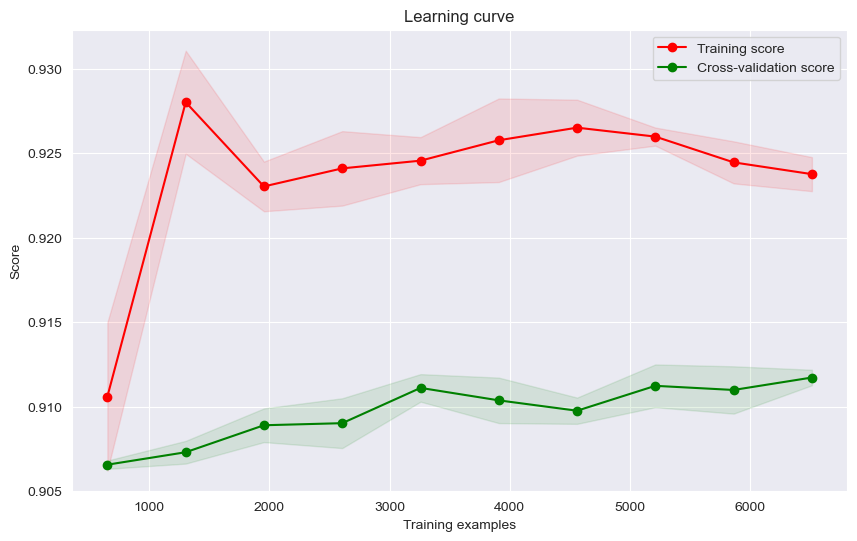

In [11]:
# plot the learning curve
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold

# Define the stratified k-fold cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=cv, n_jobs=-1
)


train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning curve')
plt.legend(loc='best')
plt.show()

In [12]:
# # Let's convert the model to ONNX
# onnx_model = convert_sklearn(
#     pipeline, initial_types=[('X', FloatTensorType((None, X.shape[1])))],
#     target_opset=12)
# 
# # Let's check the accuracy of the converted model
# sess = rt.InferenceSession(onnx_model.SerializeToString())
# y_pred_onnx =  sess.run(None, {'X': X_test.values.astype(np.float32)})
# 
# accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx[0])
# print('Accuracy of the ONNX model: ', accuracy_onnx_model)

In [13]:
# Let's save the model
# onnx.save(onnx_model, "model/good_model.onnx")

# Let's load the model
new_session = rt.InferenceSession("model/good_model.onnx")

# Let's predict the target
y_pred_onnx2 =  new_session.run(None, {'X': X_test.values.astype(np.float32)})

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx2[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)


Accuracy of the ONNX model:  0.7309769268532155


In [14]:
# Check how imbalanced the training and testing datasets are

y_train.value_counts(normalize=True)
# y_test.value_counts(normalize=True)

checked
0   0.9066
1   0.0934
Name: proportion, dtype: float64

In [15]:
# Metamorphic testing: (Other than fairness testing)
# If a value changes then the prediction likelihood should change too in line with the purpose of the model 
# pla_historie_ontwikkeling 0 or 25 // number of developments in PLA history

# Load the model
testing_session = rt.InferenceSession("model/good_model.onnx")


# Initialize variables to store likelihoods
likelihoods_0 = []
likelihoods_25 = []

# Iterate through each sample in the test set
for index, row in X_test.iterrows():
    # Convert the row to a DataFrame to ensure it's a DataFrame object
    X_sample = pd.DataFrame(row).transpose()

    # Make predictions for 0 developments in PLA history
    X_sample_0 = X_sample.copy()
    X_sample_0['pla_historie_ontwikkeling'] = 0
    y_proba_0 = testing_session.run(None, {'X': X_sample_0.values.astype(np.float32)})[1][0]

    # Make predictions for 25 developments in PLA history
    X_sample_25 = X_sample.copy()
    X_sample_25['pla_historie_ontwikkeling'] = 25
    y_proba_25 = testing_session.run(None, {'X': X_sample_25.values.astype(np.float32)})[1][0]

    # Append the likelihoods for both age groups
    likelihoods_0.append([y_proba_0[1]])  # Probability of class 1 (fraud) for 0 developments in PLA history
    likelihoods_25.append([y_proba_25[1]])  # Probability of class 1 (fraud) for 25 developments in PLA history

# Convert likelihoods lists to NumPy arrays
likelihoods_0 = np.array(likelihoods_0)
likelihoods_25 = np.array(likelihoods_25)

# Calculate the mean likelihoods for each group
mean_likelihood_0 = np.mean(likelihoods_0)
mean_likelihood_25 = np.mean(likelihoods_25)

print("Mean likelihood for 0 developments in PLA history:", mean_likelihood_0)
print("Mean likelihood for 25 developments in PLA history:", mean_likelihood_25)

Mean likelihood for 0 developments in PLA history: 0.471283271023615
Mean likelihood for 25 developments in PLA history: 0.35029586115243916


In [16]:
# contacten_onderwerp_no_show // Contact subject client has not shown up for meeting
likelihoods_show = []
likelihoods_noshow = []

# Iterate through each sample in the test set
for index, row in X_test.iterrows():
    # Convert the row to a DataFrame to ensure it's a DataFrame object
    X_sample = pd.DataFrame(row).transpose()

    # Make predictions for a client that has shown up for meetings
    X_sample_show = X_sample.copy()
    X_sample_show['contacten_onderwerp_no_show'] = 0.0
    y_proba_show = testing_session.run(None, {'X': X_sample_show.values.astype(np.float32)})[1][0]

    # Make predictions for no show client
    X_sample_noshow = X_sample.copy()
    X_sample_noshow['contacten_onderwerp_no_show'] = 1.0
    y_proba_noshow = testing_session.run(None, {'X': X_sample_noshow.values.astype(np.float32)})[1][0]

    # Append the likelihoods for both age groups
    likelihoods_show.append([y_proba_show[1]])  # Probability of class 1 (fraud) for a client that has shown up for meetings
    likelihoods_noshow.append([y_proba_noshow[1]])  # Probability of class 1 (fraud) for no show client

# Convert likelihoods lists to NumPy arrays
likelihoods_show = np.array(likelihoods_show)
likelihoods_noshow = np.array(likelihoods_noshow)

# Calculate the mean likelihoods for each group
mean_likelihood_show = np.mean(likelihoods_show)
mean_likelihood_noshow = np.mean(likelihoods_noshow)

print("Mean likelihood for a client that has shown up for meetings:", mean_likelihood_show)
print("Mean likelihood for no show client:", mean_likelihood_noshow)

Mean likelihood for a client that has shown up for meetings: 0.4456108526441474
Mean likelihood for no show client: 0.4534078462485537


In [17]:
# instrument_ladder_huidig_activering // instrument ladder is currently activated
likelihoods_notactivated = []
likelihoods_activated = []

# Iterate through each sample in the test set
for index, row in X_test.iterrows():
    # Convert the row to a DataFrame to ensure it's a DataFrame object
    X_sample = pd.DataFrame(row).transpose()

    # Make predictions for a client without an activated instrument ladder
    X_sample_notactivated = X_sample.copy()
    X_sample_notactivated['instrument_ladder_huidig_activering'] = 0.0
    y_proba_notactivated = testing_session.run(None, {'X': X_sample_notactivated.values.astype(np.float32)})[1][0]

    # Make predictions for a client with an activated instrument ladder
    X_sample_activated = X_sample.copy()
    X_sample_activated['instrument_ladder_huidig_activering'] = 1.0
    y_proba_activated = testing_session.run(None, {'X': X_sample_activated.values.astype(np.float32)})[1][0]

    # Append the likelihoods for both age groups
    likelihoods_notactivated.append([y_proba_notactivated[1]])  # Probability of class 1 (fraud) for a client without an activated instrument ladder
    likelihoods_activated.append([y_proba_activated[1]])  # Probability of class 1 (fraud) for a client with an activated instrument ladder

# Convert likelihoods lists to NumPy arrays
likelihoods_notactivated = np.array(likelihoods_notactivated)
likelihoods_activated = np.array(likelihoods_activated)

# Calculate the mean likelihoods for each group
mean_likelihood_notactivated = np.mean(likelihoods_notactivated)
mean_likelihood_activated = np.mean(likelihoods_activated)

print("Mean likelihood for a client without an activated instrument ladder:", mean_likelihood_notactivated)
print("Mean likelihood for a client with an activated instrument ladder:", mean_likelihood_activated)

Mean likelihood for a client without an activated instrument ladder: 0.4988814759441726
Mean likelihood for a client with an activated instrument ladder: 0.4338535932155585


In [18]:
# instrument_reden_beeindiging_historie_succesvol // successful instrumentation history
likelihoods_not = []
likelihoods_successful = []

# Iterate through each sample in the test set
for index, row in X_test.iterrows():
    # Convert the row to a DataFrame to ensure it's a DataFrame object
    X_sample = pd.DataFrame(row).transpose()

    # Make predictions for a client without a successful instrumentation history
    X_sample_not = X_sample.copy()
    X_sample_not['instrument_reden_beeindiging_historie_succesvol'] = 0.0
    y_proba_not = testing_session.run(None, {'X': X_sample_not.values.astype(np.float32)})[1][0]

    # Make predictions for a client with a successful instrumentation history
    X_sample_successful = X_sample.copy()
    X_sample_successful['instrument_reden_beeindiging_historie_succesvol'] = 1.0
    y_proba_successful = testing_session.run(None, {'X': X_sample_successful.values.astype(np.float32)})[1][0]

    # Append the likelihoods for both age groups
    likelihoods_not.append([y_proba_not[1]])  # Probability of class 1 (fraud) for a client without a successful instrumentation history
    likelihoods_successful.append([y_proba_successful[1]])  # Probability of class 1 (fraud) for a client with a successful instrumentation history

# Convert likelihoods lists to NumPy arrays
likelihoods_not = np.array(likelihoods_not)
likelihoods_successful = np.array(likelihoods_successful)

# Calculate the mean likelihoods for each group
mean_likelihood_not = np.mean(likelihoods_not)
mean_likelihood_successful = np.mean(likelihoods_successful)

print("Mean likelihood for a client without a successful instrumentation history:", mean_likelihood_not)
print("Mean likelihood for a client with a successful instrumentation history:", mean_likelihood_successful)

Mean likelihood for a client without a successful instrumentation history: 0.4818118895510569
Mean likelihood for a client with a successful instrumentation history: 0.4691817669465838


In [19]:
# Combinatorial/fairness testing: 
# Evaluate the model's performance and predictions separately for different demographic groups (e.g., age groups, genders) and compare the outcomes to detect any disparities or biases.
# Test case sets that test age groups, gender, if they have children and if they speak another language than dutch

age_groups = {
    'young_adult': [18, 30],  # 20-64 years old
    'youngish_adult': [31, 40],  # 20-64 years old
    'middle_aged_adult': [41, 50],  # 20-64 years old
    'older_adult': [51, 60],  # 20-64 years old
    'senior': [61, 120]  # 65+ years old (assuming 120 as upper limit)
}

results = {}
X_test_age = X_test.copy()

# Extract age information from the test set
X_test_age['age_group'] = pd.cut(X_test_age['persoon_leeftijd_bij_onderzoek'], bins=[0, 30, 40, 50, 60, 120], labels=['young_adult', 'youngish_adult', 'middle_aged_adult', 'older_adult', 'senior'])

# Evaluate model performance for each age group
for group in X_test_age['age_group'].unique():
    # Filter test set for the current age group
    X_group = X_test_age[X_test_age['age_group'] == group].drop(columns=['age_group'])
    y_group = y_test[X_test_age['age_group'] == group]

    # Predict using the model
    y_pred_group = testing_session.run(None, {'X': X_group.values.astype(np.float32)})[0]

    # Calculate evaluation metrics
    accuracy_group = accuracy_score(y_group, y_pred_group)
    precision_group = precision_score(y_group, y_pred_group)
    recall_group = recall_score(y_group, y_pred_group)
    f1_score_group = f1_score(y_group, y_pred_group)

    # Store results for the current age group
    results[group] = {
        'Accuracy': accuracy_group,
        'Precision': precision_group,
        'Recall': recall_group,
        'F1 Score': f1_score_group
    }

# Print results for each age group
for group, metrics in results.items():
    print(f"Results for {group} age group:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print()


Results for middle_aged_adult age group:
Accuracy: 0.6093
Precision: 0.1782
Recall: 0.9474
F1 Score: 0.3000

Results for older_adult age group:
Accuracy: 0.8992
Precision: 0.2235
Recall: 0.7600
F1 Score: 0.3455

Results for youngish_adult age group:
Accuracy: 0.4931
Precision: 0.2808
Recall: 0.9828
F1 Score: 0.4368

Results for senior age group:
Accuracy: 0.8641
Precision: 0.3934
Recall: 0.8276
F1 Score: 0.5333

Results for young_adult age group:
Accuracy: 0.5570
Precision: 0.3750
Recall: 1.0000
F1 Score: 0.5455


In [20]:
# Gender test

# Initialize a dictionary to store results for each gender group
results = {}
X_test_gender = X_test.copy()

# Extract gender information from the test set
X_test_gender['gender'] = X_test_gender['persoon_geslacht_vrouw'].apply(lambda x: 'woman' if x == 1.0 else 'man')

# Evaluate model performance for each gender group
for group in X_test_gender['gender'].unique():
    # Filter test set for the current gender group
    X_group = X_test_gender[X_test_gender['gender'] == group].drop(columns=['gender'])
    y_group = y_test[X_test_gender['gender'] == group]

    # Predict using the model
    y_pred_group = testing_session.run(None, {'X': X_group.values.astype(np.float32)})[0]

    # Calculate evaluation metrics
    accuracy_group = accuracy_score(y_group, y_pred_group)
    precision_group = precision_score(y_group, y_pred_group)
    recall_group = recall_score(y_group, y_pred_group)
    f1_score_group = f1_score(y_group, y_pred_group)

    # Store results for the current gender group
    results[group] = {
        'Accuracy': accuracy_group,
        'Precision': precision_group,
        'Recall': recall_group,
        'F1 Score': f1_score_group
    }

# Print results for each gender group
for group, metrics in results.items():
    print(f"Results for {group} gender group:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print()

Results for woman gender group:
Accuracy: 0.7226
Precision: 0.2353
Recall: 0.9639
F1 Score: 0.3783

Results for man gender group:
Accuracy: 0.7383
Precision: 0.2582
Recall: 0.8879
F1 Score: 0.4000


In [21]:
# Language test

# Initialize a dictionary to store results for each language group
results = {}
X_test_language = X_test.copy()

# Extract language information from the test set
X_test_language['language'] = X_test_language['persoonlijke_eigenschappen_spreektaal_anders'].apply(lambda x: 'other_language' if x == 1.0 else 'not')

# Evaluate model performance for each language group
for group in X_test_language['language'].unique():
    # Filter test set for the current language group
    X_group = X_test_language[X_test_language['language'] == group].drop(columns=['language'])
    y_group = y_test[X_test_language['language'] == group]

    # Predict using the model
    y_pred_group = testing_session.run(None, {'X': X_group.values.astype(np.float32)})[0]

    # Calculate evaluation metrics
    accuracy_group = accuracy_score(y_group, y_pred_group)
    precision_group = precision_score(y_group, y_pred_group)
    recall_group = recall_score(y_group, y_pred_group)
    f1_score_group = f1_score(y_group, y_pred_group)

    # Store results for the current language group
    results[group] = {
        'Accuracy': accuracy_group,
        'Precision': precision_group,
        'Recall': recall_group,
        'F1 Score': f1_score_group
    }

# Print results for each language group
for group, metrics in results.items():
    print(f"Results for {group} language group:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print()

Results for not language group:
Accuracy: 0.7541
Precision: 0.2550
Recall: 0.9184
F1 Score: 0.3991

Results for other_language language group:
Accuracy: 0.7037
Precision: 0.2394
Recall: 0.9239
F1 Score: 0.3803


In [22]:
# children test

# Initialize a dictionary to store results for each children group
results = {}
X_test_children = X_test.copy()

# Extract gender information from the test set
X_test_children['children'] = X_test_children['relatie_kind_heeft_kinderen'].apply(lambda x: 'has_child' if x == 1.0 else 'not')

# Evaluate model performance for each children group
for group in X_test_children['children'].unique():
    # Filter test set for the current children group
    X_group = X_test_children[X_test_children['children'] == group].drop(columns=['children'])
    y_group = y_test[X_test_children['children'] == group]

    # Predict using the model
    y_pred_group = testing_session.run(None, {'X': X_group.values.astype(np.float32)})[0]

    # Calculate evaluation metrics
    accuracy_group = accuracy_score(y_group, y_pred_group)
    precision_group = precision_score(y_group, y_pred_group)
    recall_group = recall_score(y_group, y_pred_group)
    f1_score_group = f1_score(y_group, y_pred_group)

    # Store results for the current children group
    results[group] = {
        'Accuracy': accuracy_group,
        'Precision': precision_group,
        'Recall': recall_group,
        'F1 Score': f1_score_group
    }

# Print results for each children group
for group, metrics in results.items():
    print(f"Results for {group} children group:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print()

Results for not children group:
Accuracy: 0.7560
Precision: 0.2524
Recall: 0.9068
F1 Score: 0.3948

Results for has_child children group:
Accuracy: 0.6825
Precision: 0.2394
Recall: 0.9444
F1 Score: 0.3820


In [23]:
# Age test
# Initialize variables to store counts
same_predictions_count = 0
total_samples = len(X_test)

# Iterate through each sample in the test set
for index, row in X_test.iterrows():
    # Convert the row to a DataFrame to ensure it's a DataFrame object
    X_sample = pd.DataFrame(row).transpose()

    # Make predictions for age 25
    X_sample_25 = X_sample.copy()
    X_sample_25['persoon_leeftijd_bij_onderzoek'] = 25
    y_pred_25 = testing_session.run(None, {'X': X_sample_25.values.astype(np.float32)})

    # Make predictions for age 65
    X_sample_65 = X_sample.copy()
    X_sample_65['persoon_leeftijd_bij_onderzoek'] = 65
    y_pred_65 = testing_session.run(None, {'X': X_sample_65.values.astype(np.float32)})

    # Check if predictions are the same
    if y_pred_25 == y_pred_65:
        same_predictions_count += 1

# Calculate the fraction of cases where the predictions are the same
fraction_same_predictions = same_predictions_count / total_samples

print("Fraction of cases where predictions are the same for age 25 and 65:", fraction_same_predictions)

Fraction of cases where predictions are the same for age 25 and 65: 0.0


In [24]:
# Gender test
# Initialize variables to store counts
same_predictions_count = 0
total_samples = len(X_test)

# Iterate through each sample in the test set
for index, row in X_test.iterrows():
    # Convert the row to a DataFrame to ensure it's a DataFrame object
    X_sample = pd.DataFrame(row).transpose()

    # Make predictions for men
    X_sample_men = X_sample.copy()
    X_sample_men['persoon_geslacht_vrouw'] = 0.0
    y_pred_men = testing_session.run(None, {'X': X_sample_men.values.astype(np.float32)})

    # Make predictions for women
    X_sample_women = X_sample.copy()
    X_sample_women['persoon_geslacht_vrouw'] = 1.0
    y_pred_women = testing_session.run(None, {'X': X_sample_women.values.astype(np.float32)})

    # Check if predictions are the same
    if y_pred_men == y_pred_women:
        same_predictions_count += 1

# Calculate the fraction of cases where the predictions are the same
fraction_same_predictions = same_predictions_count / total_samples

print("Fraction of cases where predictions are the same for men and women:", fraction_same_predictions)

Fraction of cases where predictions are the same for men and women: 1.0


In [25]:
# Language test
# Initialize variables to store counts
same_predictions_count = 0
total_samples = len(X_test)

# Iterate through each sample in the test set
for index, row in X_test.iterrows():
    # Convert the row to a DataFrame to ensure it's a DataFrame object
    X_sample = pd.DataFrame(row).transpose()

    # Make predictions for not
    X_sample_not = X_sample.copy()
    X_sample_not['persoonlijke_eigenschappen_spreektaal_anders'] = 0.0
    y_pred_not = testing_session.run(None, {'X': X_sample_not.values.astype(np.float32)})

    # Make predictions for other
    X_sample_other = X_sample.copy()
    X_sample_other['persoonlijke_eigenschappen_spreektaal_anders'] = 1.0
    y_pred_other = testing_session.run(None, {'X': X_sample_other.values.astype(np.float32)})

    # Check if predictions are the same
    if y_pred_not == y_pred_other:
        same_predictions_count += 1

# Calculate the fraction of cases where the predictions are the same
fraction_same_predictions = same_predictions_count / total_samples

print("Fraction of cases where predictions are the same for dutch speakers and non-dutch speakers:", fraction_same_predictions)

Fraction of cases where predictions are the same for dutch speakers and non-dutch speakers: 1.0


In [26]:
# Children test
# Initialize variables to store counts
same_predictions_count = 0
total_samples = len(X_test)

# Iterate through each sample in the test set
for index, row in X_test.iterrows():
    # Convert the row to a DataFrame to ensure it's a DataFrame object
    X_sample = pd.DataFrame(row).transpose()

    # Make predictions for not
    X_sample_not = X_sample.copy()
    X_sample_not['relatie_kind_heeft_kinderen'] = 0.0
    y_pred_not = testing_session.run(None, {'X': X_sample_not.values.astype(np.float32)})

    # Make predictions for other
    X_sample_children = X_sample.copy()
    X_sample_children['relatie_kind_heeft_kinderen'] = 1.0
    y_pred_children = testing_session.run(None, {'X': X_sample_children.values.astype(np.float32)})

    # Check if predictions are the same
    if y_pred_not == y_pred_children:
        same_predictions_count += 1

# Calculate the fraction of cases where the predictions are the same
fraction_same_predictions = same_predictions_count / total_samples

print("Fraction of cases where predictions are the same for people with or without children:", fraction_same_predictions)

Fraction of cases where predictions are the same for people with or without children: 1.0
